In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
results_path = '../avalia/'

## Read Results

- results ordere by ranking

In [5]:
result = pd.read_csv('../results/resultados.csv', sep=';')
result['doc'] = result['Result'].str.replace("'", "").str.split(', ', expand=True)[1].astype(int)

In [4]:
result[result['QueryNumber'] == 2].head()

,QueryNumber,Result,doc
1215,2,"[1, '01197', 0.39932430829602683]",1197
1216,2,"[2, '00333', 0.40721323905884554]",333
1217,2,"[3, '00767', 0.4154448208992295]",767
1218,2,"[4, '00176', 0.434097174590214]",176
1219,2,"[5, '00986', 0.43861929397921473]",986


In [6]:
esperados = pd.read_csv('../results/esperados.csv', sep=';')

In [44]:
esperados[esperados['QueryNumber'] == 2].head()

,QueryNumber,DocNumber,DocVotes
34,2,169,1
35,2,434,2
36,2,454,1
37,2,498,1
38,2,499,1


## Calculate Precision x Recall Curve

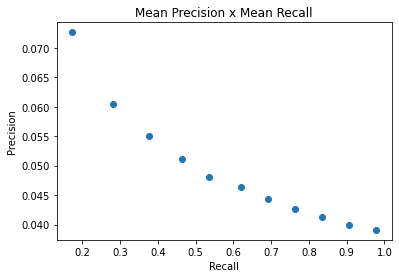

In [138]:
number_of_points = 11
queries_set = set(result['QueryNumber'].to_list())
queries_precisions = []
queries_recalls = []

for query in queries_set:
  precisions = []
  recalls = []
  
  relevant_documents = esperados.loc[esperados['QueryNumber'] == query, 'DocNumber'].to_list()
  retrieveds = result.loc[result['QueryNumber'] == query, 'doc'].to_list()
  
  step = round(len(retrieveds)/number_of_points)
  for p in range(number_of_points):
    retrieveds_until = retrieveds[:(p+1)*step]

    tp = len(set(relevant_documents).intersection(retrieveds_until))
    
    precisions.append(tp/len(retrieveds_until))
    recalls.append(tp/len(relevant_documents))

  queries_precisions.append(precisions)
  queries_recalls.append(recalls)

mean_precisions = np.mean(np.array(queries_precisions), axis=0)
mean_recalls = np.mean(np.array(queries_recalls), axis=0)

precision_recall_df = pd.DataFrame(np.array([mean_precisions, mean_recalls]).T, columns=["Precision", "Recall"])
precision_recall_df.to_csv(results_path + "11pontos-stemmer-1.csv", sep=";", index=False)

plt.scatter(mean_recalls, mean_precisions)
plt.title("Mean Precision x Mean Recall")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Calculate F1
- For these calculation, consider that the documents retrived were the first 10 in ranking

In [110]:
precisions = []
recalls = []
queries_set = set(result['QueryNumber'].to_list())

for query in queries_set:
  
  relevant_documents = esperados.loc[esperados['QueryNumber'] == query, 'DocNumber'].to_list()
  retrieveds_until = result.loc[result['QueryNumber'] == query, 'doc'].to_list()[:10]
  
  tp = len(set(relevant_documents).intersection(retrieveds_until))
  
  precisions.append(tp/len(retrieveds_until))
  recalls.append(tp/len(relevant_documents))

mean_precisions = np.mean(np.array(precisions))
mean_recalls = np.mean(np.array(recalls))


f1 = (2 * mean_precisions * mean_recalls)/(mean_precisions + mean_recalls)

print(f1*100)

5.788552078479641


## Calculate Precision@K

In [143]:
def precision_at_k(result, esperados, query, k):
  relevant_documents = esperados.loc[esperados['QueryNumber'] == query, 'DocNumber'].to_list()
  retrieveds_until = result.loc[result['QueryNumber'] == query, 'doc'].to_list()[:k]
  tp = len(set(relevant_documents).intersection(retrieveds_until))
  return tp/len(retrieveds_until)

def mean_precision_at_k(k, result, esperados):
  precisions = []
  queries_set = set(result['QueryNumber'].to_list())
  for query in queries_set:
    precisions.append(precision_at_k(result, esperados, query, k))

  mean_precisions = np.mean(np.array(precisions))

  return mean_precisions

- Precision@5

In [141]:
mean_precision_at_k(5, result, esperados)*100

19.19191919191919

- Precision@10

In [137]:
mean_precision_at_k(10, result, esperados)*100

15.95959595959596

## Calculate Histogram R precision
- comparative: query_precision_1 - query_precision_2
- considering rank = 10

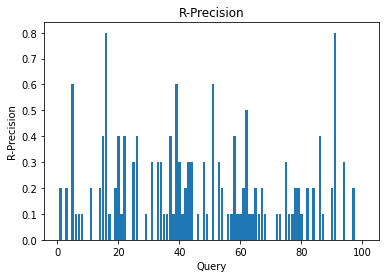

In [128]:
def r_precisions_calc(result, esperados):
  r_precisions = []
  queries_set = set(result['QueryNumber'].to_list())
  for query in queries_set:
    relevant_documents = esperados.loc[esperados['QueryNumber'] == query, 'DocNumber'].to_list()
    # Difference is that k is fixed to 10, as it is our ranking
    retrieveds_until = result.loc[result['QueryNumber'] == query, 'doc'].to_list()[:10]

    tp = len(set(relevant_documents).intersection(retrieveds_until))
    r_precisions.append(tp/len(retrieveds_until))
    
  return queries_set, r_precisions

queries_set, r_precisions = r_precisions_calc(result, esperados)

r_precisions_df = pd.DataFrame({'r_precision': r_precisions, 'query': list(queries_set)})
# r_precisions_df.to_csv(evaluations_dir + "r-precision-stemmer-1.csv", sep=";", index=False)

plt.bar(list(queries_set),r_precisions)
plt.title("R-Precision")
plt.xlabel("Query")
plt.ylabel("R-Precision")
plt.show()

## Calculate MAP

In [144]:
def mean_average_precision(result, esperados):
  rank_map = []
  queries_set = set(result['QueryNumber'].to_list())
  for query in queries_set:
    precisions = []
    relevant_documents = esperados.loc[esperados['QueryNumber'] == query, 'DocNumber'].to_list()
    retrieveds = result.loc[result['QueryNumber'] == query, 'doc'].to_list()
    
    ks = []
    for k, ret in enumerate(retrieveds):
      if ret in relevant_documents:
        ks.append(k)
    
    for k in ks:
      precisions.append(precision_at_k(result, esperados, query, k+1))

    rank_map.append(np.mean(np.array(precisions)))

  map = np.mean(np.array(rank_map))

  return map

map = mean_average_precision(result, esperados)
map*100

7.783531628016907

## Calculate MRR

In [149]:
def mean_reciprocal_rank(result, esperados):
  reciprocal_ranks = []
  queries_set = set(result['QueryNumber'].to_list())
  for query in queries_set:
    relevant_documents = esperados.loc[esperados['QueryNumber'] == query, 'DocNumber'].to_list()
    retrieveds = result.loc[result['QueryNumber'] == query, 'doc'].to_list()[:10]

    reciprocal_rank = 0
    for k, ret in enumerate(retrieveds):
      if ret in relevant_documents:
        reciprocal_rank = 1/(k + 1)
        break
      
    reciprocal_ranks.append(reciprocal_rank)    

  mean_reciprocal_rank = np.mean(reciprocal_ranks)

  return mean_reciprocal_rank

mrr = mean_reciprocal_rank(result, esperados)
mrr*100

35.56677890011223

## Discounted Cumulative Gain

In [7]:
def mean_discounted_cumulative_gain(result, esperados):
  discounted_cumulative_gains = []
  queries_set = set(result['QueryNumber'].to_list())
  
  for query in queries_set:
    dcg = 0
    relevant_documents = esperados.loc[esperados['QueryNumber'] == query, 'DocNumber'].to_list()
    scores = esperados.loc[esperados['QueryNumber'] == query, 'DocVotes'].to_list()
    retrieveds_until = result.loc[result['QueryNumber'] == query, 'doc'].to_list()[:10] 
    
    for k, ret in enumerate(retrieveds_until):
      if ret in relevant_documents:
        rel_pos = relevant_documents.index(ret)
        score = scores[rel_pos]
        if k == 0:
          dcg += score
        else:
          dcg += score/np.log2(k+1)
    discounted_cumulative_gains.append(dcg)
  mean_dcg = np.mean(discounted_cumulative_gains)

  return mean_dcg

mean_dcg = mean_discounted_cumulative_gain(result, esperados)

mean_dcg

3.3528116495541944

## Normalized Discounted Cumulative Gain

In [17]:
discounted_cumulative_gains = []
queries_set = set(result['QueryNumber'].to_list())
  
for query in queries_set:
    dcg = 0
    dcg_max = 0
    relevant_documents = esperados.loc[esperados['QueryNumber'] == query, 'DocNumber'].to_list()
    scores = esperados.loc[esperados['QueryNumber'] == query, 'DocVotes'].to_list()
    retrieveds_until = result.loc[result['QueryNumber'] == query, 'doc'].to_list()[:10] 
    
    scores_ret = []
    for k, ret in enumerate(retrieveds_until):
      if ret in relevant_documents:
        rel_pos = relevant_documents.index(ret)
        score = scores[rel_pos]
        scores_ret.append(score)
        if k == 0:
          dcg += score
        else:
          dcg += score/np.log2(k+1)  
    scores_ret_ord = np.sort(scores_ret)[::-1]
    for i, score in enumerate(scores_ret_ord):
        if i == 0:
          dcg_max += score
        else:
          dcg_max += score/np.log2(i+1)  
    if dcg_max > 0:
      discounted_cumulative_gains.append(dcg/dcg_max)
    else: 
      discounted_cumulative_gains.append(0)
 

mean_dcg = np.mean(discounted_cumulative_gains)
mean_dcg

0.4036582855309668